In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date

### get data

In [27]:
%%time 
##----------------------------------------------------
## 20CR apcp, only for 1950-2014, tropical australia
##----------------------------------------------------
filelist=[]
for i in range(1950,2015,1):
    filelist.append(f'/Users/dongxiay/Documents/data/daily/apcp.{i}.nc')
ds1=xr.open_mfdataset(filelist,combine='by_coords')
ds=ds1['apcp'].loc[:,-45:0,100:160]

##----------------------------------------------------
##OT12 MJO, if amplitude <1, make phase =0
##----------------------------------------------------
df=pd.read_csv("/Users/dongxiay/Documents/data/MJO_ot12.csv")
df['time']=pd.to_datetime(df[['year','month','day']])
df=df.set_index('time').drop(columns=['year','month','day'])
df.loc[df['amplitude'].lt(1) ,'phase'] = 0

##----------------------------------------------------
##NINO3.4, monthly resample to daily, nino34>1 elnino, nino34<-1 lanina, else neatural
##----------------------------------------------------
nino=pd.read_csv("https://psl.noaa.gov/data/correlation/nina34.anom.data",
                sep='  ', skiprows=3,skipfooter=4,names=np.arange(1,13))
nino=nino.reset_index()
nino_long = pd.melt(nino,id_vars='index')
nino_long = nino_long.rename(columns={'index':'year','variable':'month'})
nino_long['day'] = 1
nino_long['time'] = pd.to_datetime(nino_long[['year','month','day']])
nino_long = nino_long[['time','value']]
nino_long = nino_long.set_index('time').resample('1d').ffill()

nino_long.loc[nino_long['value']<(-1) ,'watch'] = -1
nino_long.loc[nino_long['value']>(1) ,'watch'] = 1
nino_long.loc[(nino_long['value']>(-1)) & (nino_long['value']<(1)),'watch']=0

df2=nino_long

##merge
dfmjo=df.loc[(df.index >= ds.time.min().values) & (df.index <= ds.time.max().values)][['amplitude','phase']]
dfenso=df2.loc[(df2.index >= ds.time.min().values) & (df2.index <= ds.time.max().values)]['watch']
data=xr.merge([ds,dfmjo.to_xarray(),dfenso.to_xarray()],join='inner').load()

data

/Users/dongxiay/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


CPU times: user 27.3 s, sys: 1.35 s, total: 28.7 s
Wall time: 29.8 s


<xarray.Dataset>
Dimensions:    (lat: 46, lon: 61, time: 23741)
Coordinates:
  * lat        (lat) float32 -45.0 -44.0 -43.0 -42.0 ... -3.0 -2.0 -1.0 0.0
  * lon        (lon) float32 100.0 101.0 102.0 103.0 ... 157.0 158.0 159.0 160.0
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
Data variables:
    apcp       (time, lat, lon) float32 0.75 0.6625 0.575 ... 1.8 1.688 1.588
    amplitude  (time) float64 1.864 1.572 1.284 1.084 ... 1.378 1.279 0.9522
    phase      (time) int64 5 5 6 6 0 0 0 0 0 0 0 0 ... 2 2 3 3 3 3 3 4 4 4 4 0
    watch      (time) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/14)
    long_name:         daily mean 3-hourly accumulated total precipitation at...
    units:             kg/m^2
    GRIB_name:         APCP
    var_desc:          Precipitation amount
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si Dai...
    level_desc:        Surface
    ...                ...
    standard_name:     precipitation_amount
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ 0.     35.1375]

###  Ratio=Result/baseline for Lanina
Result= (number of days when rainfall exceeding the 90% threshold (THR) for MJO phase 1) / (number of days that is in MJO phase 1)

baseline= (number of days when rainfall exceeding the THR) / (total days for all Lanina days)

In [28]:
##only select wet season NOV-APR
data = data.sel(time=data.time.dt.month.isin([1, 2, 3, 4, 11, 12]))

In [30]:
##only select Lanina
datanina = data['apcp'].loc[data.watch== -1]
phasenina= data['phase'].loc[data.watch== -1]

def func(ds):
    return ds.count('time') / len(ds['time'])

THR=0.90
##----------------------------------------------------
# INCLUDE no-rain days for 90% threshold
##----------------------------------------------------
#THR_threshold = datanina.where(datanina!=0).chunk(dict(time=-1)).quantile(THR, dim='time')
THR_threshold = datanina.chunk(dict(time=-1)).quantile(THR, dim='time')

baseline = datanina.where(datanina >= THR_threshold).count('time') / len(datanina['time'])
baseline=baseline.compute() 

result = datanina.where(datanina >= THR_threshold).groupby(phasenina).apply(func).compute()
ratio= result/baseline
obs=ratio

### significance:  Monte carlo two-side test

#### create MJO phase ensembles to prepare for the monte carlo

In [ ]:
phasenina=phasenina.to_dataframe()

In [35]:
def create_mjo_ensemble(df_, col, steps):
    df = df_.copy()
    for stp in steps:
        df[f"{col}_{stp}"] = df[col].shift(stp)
        df=df.reset_index()
        df.loc[0:stp-1, f"{col}_{stp}"] = df.loc[len(df)-stp:, f"{col}"].values
        df = df.set_index('time')
    return df
    
# add lagging 
dfmjos = create_mjo_ensemble(phasenina, 'phase', np.arange(50,len(phasenina['phase'])-50,7))

##merge mjo emsembles with apcp
datam=xr.merge([datanina,dfmjos.to_xarray()],join='inner').load()

In [36]:
datam

<xarray.Dataset>
Dimensions:     (lat: 46, lon: 61, time: 2237)
Coordinates:
  * lat         (lat) float32 -45.0 -44.0 -43.0 -42.0 ... -3.0 -2.0 -1.0 0.0
  * lon         (lon) float32 100.0 101.0 102.0 103.0 ... 158.0 159.0 160.0
  * time        (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2011-12-31
Data variables: (12/308)
    apcp        (time, lat, lon) float32 0.75 0.6625 0.575 ... 0.0625 0.0625 0.1
    phase       (time) int64 5 5 6 6 0 0 0 0 0 0 0 0 ... 3 3 3 4 4 4 5 5 5 5 6 6
    phase_50    (time) float64 0.0 0.0 0.0 0.0 0.0 1.0 ... 6.0 6.0 0.0 0.0 0.0
    phase_57    (time) float64 5.0 5.0 6.0 6.0 0.0 0.0 ... 0.0 3.0 4.0 4.0 5.0
    phase_64    (time) float64 0.0 0.0 0.0 3.0 4.0 4.0 ... 0.0 0.0 0.0 0.0 0.0
    phase_71    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 3.0 3.0 0.0 0.0 0.0
    ...          ...
    phase_2150  (time) float64 0.0 0.0 0.0 0.0 0.0 3.0 ... 3.0 3.0 3.0 0.0 0.0
    phase_2157  (time) float64 2.0 3.0 3.0 3.0 3.0 0.0 ... 1.0 1.0 2.0 2.0 2.0
    phase_2164  (time) float64 8.0 8.0 1.0 1.0 2.0 2.0 ... 6.0 6.0 7.0 7.0 8.0
    phase_2171  (time) float64 6.0 6.0 6.0 6.0 7.0 7.0 ... 7.0 7.0 7.0 6.0 6.0
    phase_2178  (time) float64 7.0 7.0 7.0 7.0 7.0 6.0 ... 6.0 6.0 7.0 7.0 7.0
    phase_2185  (time) float64 5.0 6.0 6.0 6.0 7.0 7.0 ... 4.0 5.0 5.0 5.0 5.0
Attributes: (12/14)
    long_name:         daily mean 3-hourly accumulated total precipitation at...
    units:             kg/m^2
    GRIB_name:         APCP
    var_desc:          Precipitation amount
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si Dai...
    level_desc:        Surface
    ...                ...
    standard_name:     precipitation_amount
    valid_range:       [  0. 100.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ 0.     35.1375]

#### repeat step 2 many times to create a heavy rainfall ratio ensemble 

In [37]:
PW="phase"
a=[i for i in list(datam.keys()) if i[:len(PW)]==PW]
ratiom=ratio.expand_dims({'iteration':len(a)}).copy()

In [38]:
%%time
for i, value in enumerate(a):
    THR=0.90

    #THR_threshold = datam['apcp'].where(datam['apcp']!=0).chunk(dict(time=-1)).quantile(THR, dim='time')
    THR_threshold = datam['apcp'].chunk(dict(time=-1)).quantile(THR, dim='time')

    
    baseline = datam.where(datam['apcp'] >= THR_threshold)['apcp'].count('time') / len(datam['time'])
    baseline=baseline.compute()

    result = datam['apcp'].where(datam['apcp'] >= THR_threshold).groupby(datam[value]).apply(func).compute()
    ratio= result/baseline
    ratiom[i,:,:,:]=ratio
    
filename = "/Users/dongxiay/Documents/data/"+'ratiom_lanina_norain_90_1950-2014.nc'
ratiom.to_netcdf(filename, 'w')


CPU times: user 5min 27s, sys: 11.5 s, total: 5min 39s
Wall time: 5min 39s


#### rank the ratio calculated in step 2 among those ratio ensemble, get the significance

In [39]:
#Monte resamples
fmonte=xr.open_dataset("/Users/dongxiay/Documents/data/ratiom_lanina_norain_90_1950-2014.nc")

#ranking based on the iteration dimension for each phase/lat/lon
a=fmonte['apcp'].sortby(fmonte['iteration'])

#calculate the p-value, if obs is outside of p1/p2, then mask=1 (or true)
p1=a.quantile(0.05,dim="iteration")
p2=a.quantile(0.95,dim="iteration")

sig= xr.where((obs >= p2) | (obs <= p1), 1, -1)

### plot 

In [40]:
#select australia map only
import regionmask
mask = regionmask.defined_regions.natural_earth.countries_110.mask(obs)
AU_index = regionmask.defined_regions.natural_earth.countries_110.map_keys('AU')
ratio_AU = obs.where(mask == AU_index)
sig_AU = sig.where(mask == AU_index)

In [41]:
# import NCL colormap
import cmaps
cmap=cmaps.precip_diff_20lev
 

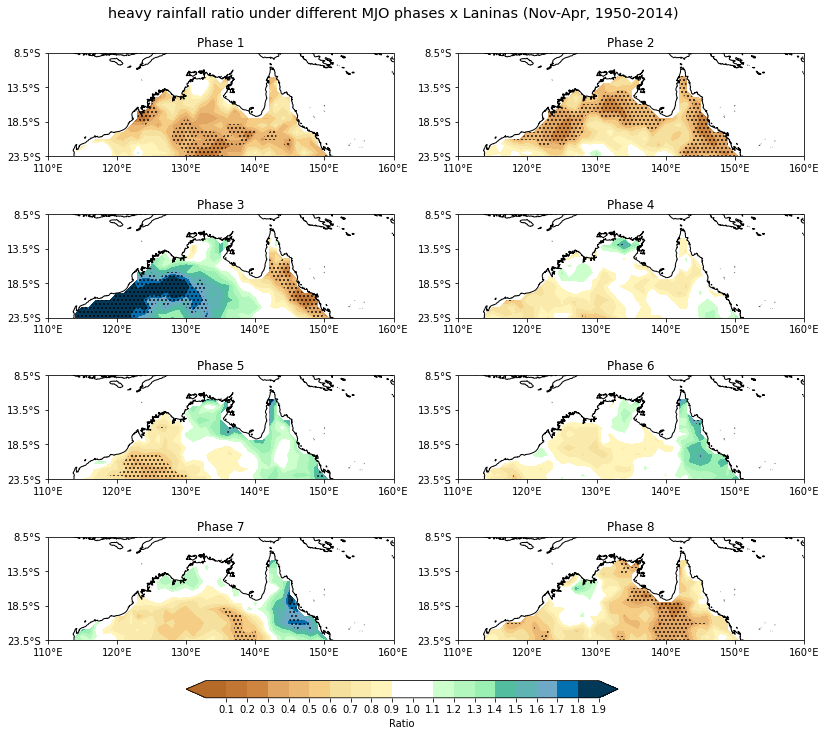

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cartopy.mpl.ticker as cticker 


leftlon, rightlon, lowerlat, upperlat = (110,160,-23.5,-10)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

title=[]
for i in range(1,9,1):
    title.append(f'Phase {i}')
   
fig = plt.figure(figsize=(12,8))

for i in range(4):
    for j in range(2):
        ax = fig.add_axes([0.1+j*0.475, 1.5-i*0.28, 0.4, 0.3],projection = ccrs.PlateCarree())
#         ax.set_title('({})'.format(title[i,j]),loc='left',fontsize=14)
        ax.set_extent(img_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE) 
        ax.set_xticks(np.arange(leftlon,rightlon+10,10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lowerlat,upperlat+5,5), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.title.set_text(title[i*2+j])
        c = ax.contourf(ratio['lon'],ratio['lat'],ratio_AU[i*2+j+1,:,:],
                        levels=np.arange(0,2,0.1),
                        extend='both' ,
                        cmap=cmap, #.precip_diff_12lev,
                        transform=ccrs.PlateCarree()) 
        #using ... to plot the 0-0.05 to show it is significant at the 5% level 
        cf2 =ax.contourf(ratio['lon'],ratio['lat'],sig_AU[i*2+j+1,:,:],[0.9,1],
                         zorder=1,hatches=['...', None],
                         colors="none", 
                         transform=ccrs.PlateCarree())
        
#colorbar, You would want to make sure the colorbar always sits in the same axes. 
# To this end, you may create a colorbar axes (cax) outside the loop
fig.colorbar(c, cax=fig.add_axes([0.26, 0.62, 0.5, 0.03 ]),
             orientation='horizontal',  
             label= 'Ratio', 
             ticks=np.arange(0.1,2.1,0.1),
             shrink=0.7)
st=fig.suptitle("heavy rainfall ratio under different MJO phases x Laninas (Nov-Apr, 1950-2014)",fontsize="x-large")
st.set_y(1.82)
fig.subplots_adjust(top=1.5)

#plt.savefig("MJOcomp_daily_rain_prob_lanina_ANN.pdf", format="pdf",bbox_inches = 'tight')